In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
from main import simulate_planes, knots_to_nm_per_min, eta_minutes

In [3]:
def run_complete_analysis(lambda_prob=0.15, total_minutes=1080, show_animation=False):
    """
    Ejecuta un análisis completo con todas las visualizaciones.
    
    Args:
        lambda_prob: Probabilidad de aparición de aeronaves
        total_minutes: Duración de la simulación
        show_animation: Si mostrar la animación (puede ser lenta)
    """
    print(f"Ejecutando simulación completa con λ = {lambda_prob}")
    print(f"Duración: {total_minutes} minutos ({total_minutes/60:.1f} horas)")
    print("-" * 60)
    
    # Ejecutar simulación
    planes, _ = simulate_planes(lambda_prob, total_minutes)
    
    # Estadísticas básicas
    landed = [p for p in planes if p.status == 'landed']
    montevideo = [p for p in planes if p.status == 'montevideo']
    en_aproximacion = [p for p in planes if p.status == 'approaching' and p.dist > 0]
    
    print(f"Total de aviones simulados: {len(planes)}")
    print(f"Aterrizados: {len(landed)} ({len(landed)/len(planes)*100:.1f}%)")
    print(f"Se fueron a Montevideo: {len(montevideo)} ({len(montevideo)/len(planes)*100:.1f}%)")
    print(f"En aproximación al final: {len(en_aproximacion)}")
    print("-" * 60)

In [5]:
run_complete_analysis()

Ejecutando simulación completa con λ = 0.15
Duración: 1080 minutos (18.0 horas)
------------------------------------------------------------
Total de aviones simulados: 151
Aterrizados: 89 (58.9%)
Se fueron a Montevideo: 60 (39.7%)
En aproximación al final: 2
------------------------------------------------------------


In [6]:
def plot_landing_times_bar(planes):
    """
    Crea un histograma de los horarios de aterrizaje.
    
    Args:
        planes: Lista de objetos Plane de la simulación
    """
    landed = [p for p in planes if p.status == 'landed' and p.landed_time is not None]
    if not landed:
        print("No hay aviones aterrizados para graficar")
        return
    
    # Convertir minutos de simulación a horas del día
    # minuto 0 = 6:00am, minuto 60 = 7:00am, etc.
    horas = [6 + (p.landed_time // 60) for p in landed]
    
    plt.figure(figsize=(12, 6))
    n, bins, patches = plt.hist(horas, bins=range(6, 25), color='skyblue', edgecolor='black', align='left', alpha=0.7)
    
    # Colorear las barras según la cantidad
    colors = cm.viridis(n / max(n))
    for patch, color in zip(patches, colors):
        patch.set_facecolor(color)
    
    plt.xlabel('Hora de aterrizaje', fontsize=12)
    plt.ylabel('Cantidad de aterrizajes', fontsize=12)
    plt.title('Distribución de aterrizajes por hora (6am a 12am)', fontsize=14)
    plt.xticks(range(6, 25))
    plt.grid(True, alpha=0.3)
    
    # Agregar valores en las barras
    for i, v in enumerate(n):
        if v > 0:
            plt.text(i + 6, v + 0.1, str(int(v)), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

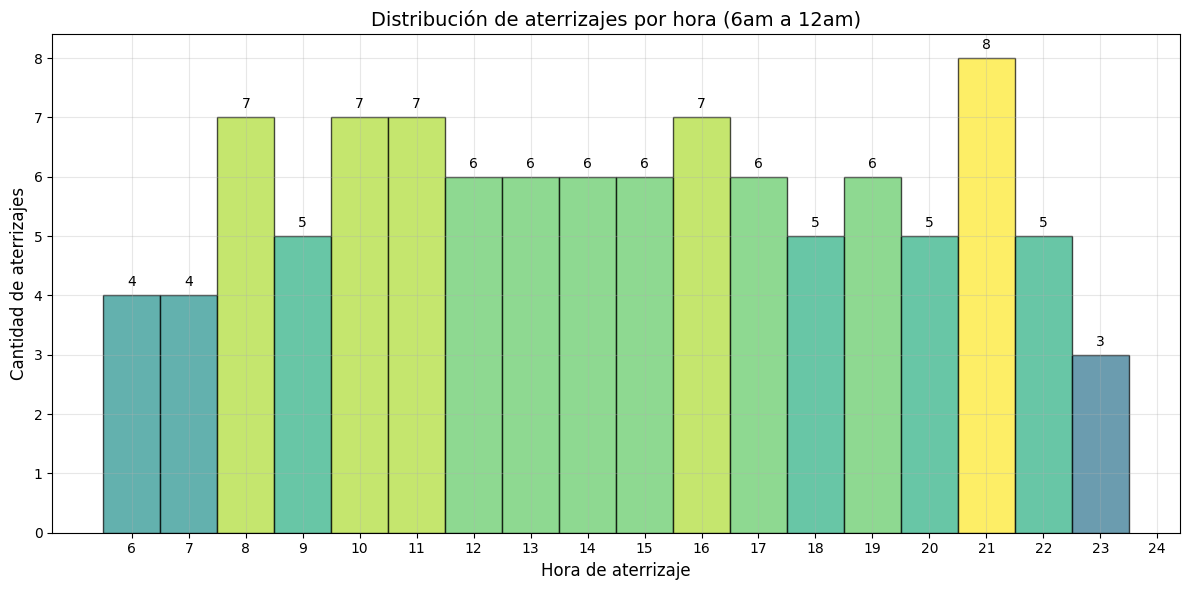

In [8]:
planes, _ = simulate_planes(0.16355, 1080)
plot_landing_times_bar(planes)

In [9]:
def plot_speed_distribution(planes):
    """
    Gráfica la distribución de velocidades durante la simulación.
    
    Args:
        planes: Lista de objetos Plane de la simulación
    """
    all_speeds = []
    all_distances = []
    
    for plane in planes:
        if plane.status in ['landed', 'montevideo']:
            # Reconstruir velocidades basándose en las posiciones
            for i in range(len(plane.positions) - 1):
                t1, d1 = plane.positions[i]
                t2, d2 = plane.positions[i + 1]
                if t2 > t1:  # Evitar división por cero
                    speed = abs(d1 - d2) / ((t2 - t1) / 60)  # nudos
                    all_speeds.append(speed)
                    all_distances.append(d1)
    
    if not all_speeds:
        print("No hay datos de velocidad para graficar")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histograma de velocidades
    ax1.hist(all_speeds, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Velocidad (nudos)', fontsize=12)
    ax1.set_ylabel('Frecuencia', fontsize=12)
    ax1.set_title('Distribución de velocidades', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Scatter plot velocidad vs distancia
    scatter = ax2.scatter(all_distances, all_speeds, alpha=0.6, c=all_distances, 
                         cmap='viridis', s=20)
    ax2.set_xlabel('Distancia a pista (mn)', fontsize=12)
    ax2.set_ylabel('Velocidad (nudos)', fontsize=12)
    ax2.set_title('Velocidad vs Distancia', fontsize=14)
    ax2.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax2, label='Distancia (mn)')
    
    plt.tight_layout()
    plt.show()

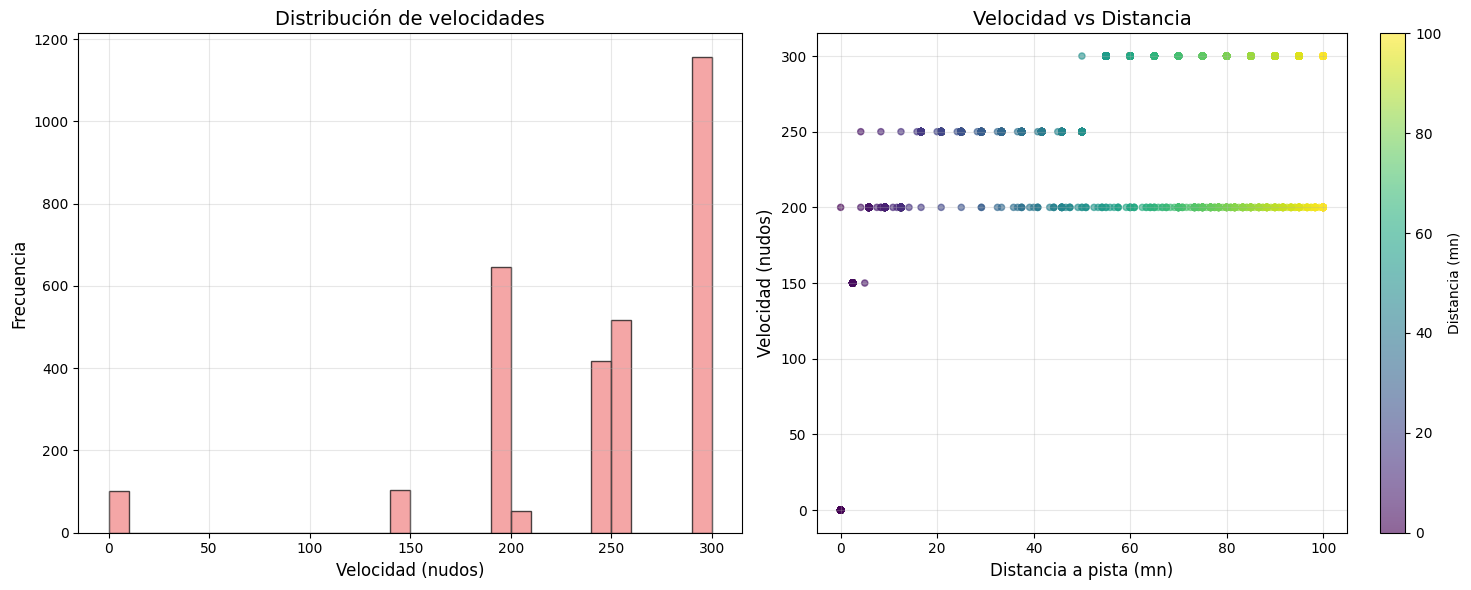

In [10]:
plot_speed_distribution(planes)


In [11]:
def plot_delay_analysis(planes):
    """
    Analiza y grafica los atrasos de las aeronaves.
    
    Args:
        planes: Lista de objetos Plane de la simulación
    """
    landed = [p for p in planes if p.status == 'landed' and p.landed_time is not None]
    if not landed:
        print("No hay aviones aterrizados para analizar atrasos")
        return
    
    def baseline_time_from_100nm():
        """Tiempo teórico mínimo desde 100mn sin congestión"""
        t = 50/(300/60) + 35/(250/60) + 10/(200/60) + 5/(150/60)
        return t
    
    baseline = baseline_time_from_100nm()
    delays = [(p.landed_time - p.appear_time) - baseline for p in landed]
    appear_times = [p.appear_time for p in landed]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Atrasos en el tiempo
    ax1.scatter(appear_times, delays, alpha=0.6, color='orange', s=30)
    ax1.set_xlabel('Minuto de aparición', fontsize=12)
    ax1.set_ylabel('Atraso (minutos)', fontsize=12)
    ax1.set_title('Atraso vs Tiempo de aparición', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Sin atraso')
    ax1.legend()
    
    # Histograma de atrasos
    ax2.hist(delays, bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Atraso (minutos)', fontsize=12)
    ax2.set_ylabel('Frecuencia', fontsize=12)
    ax2.set_title('Distribución de atrasos', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.axvline(x=np.mean(delays), color='red', linestyle='--', 
                label=f'Promedio: {np.mean(delays):.1f} min')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

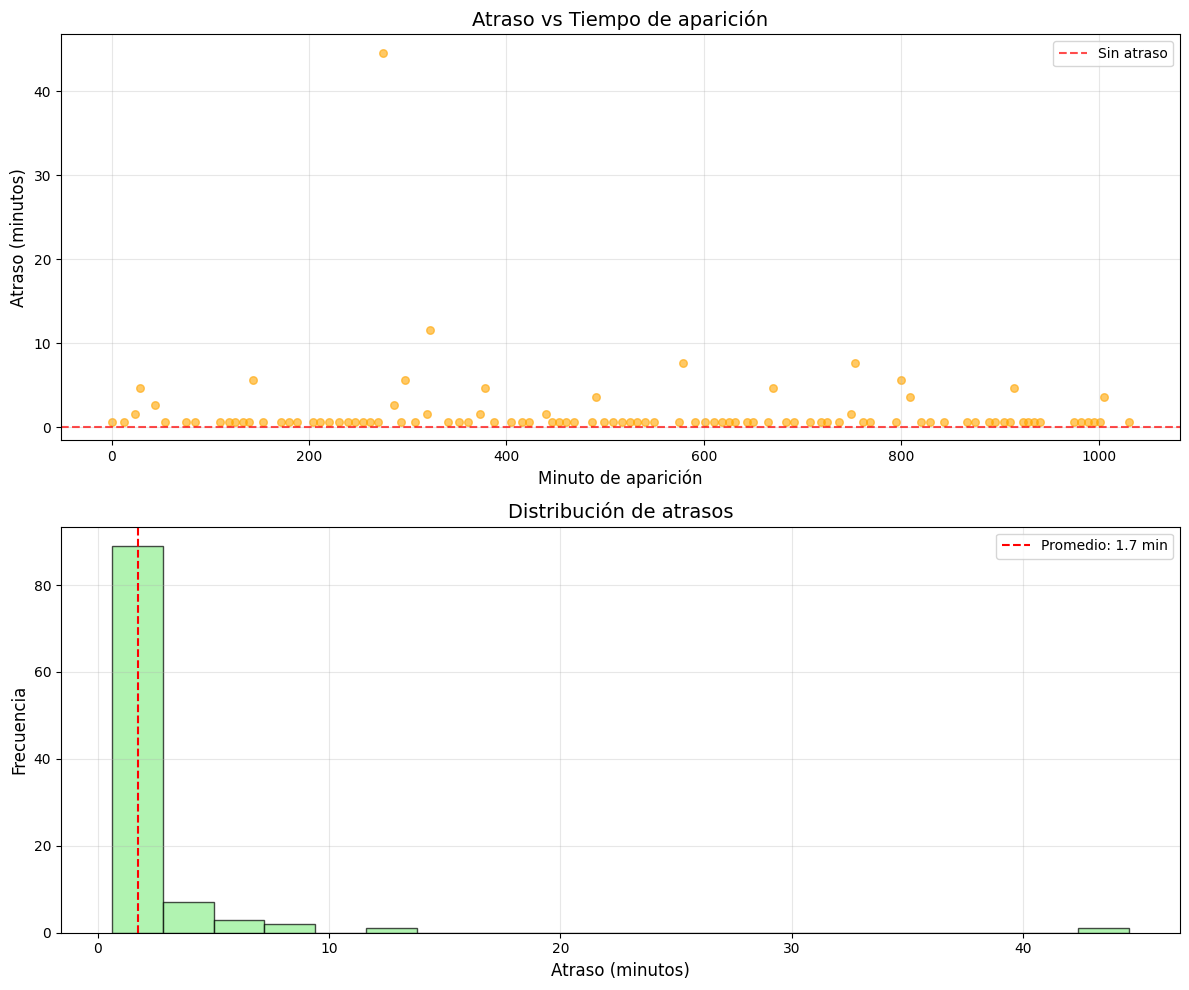

In [12]:
plot_delay_analysis(planes)


In [13]:
def plot_system_efficiency(planes):
    """
    Gráfica métricas de eficiencia del sistema.
    
    Args:
        planes: Lista de objetos Plane de la simulación
    """
    landed = len([p for p in planes if p.status == 'landed'])
    montevideo = len([p for p in planes if p.status == 'montevideo'])
    in_flight = len([p for p in planes if p.status == 'approaching'])
    
    # Gráfico de torta
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    labels = ['Aterrizados', 'Montevideo', 'En vuelo']
    sizes = [landed, montevideo, in_flight]
    colors = ['lightgreen', 'lightcoral', 'lightyellow']
    explode = (0.1, 0, 0)  # explode the first slice
    
    ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.set_title('Distribución de resultados de vuelos', fontsize=14)
    
    # Eficiencia por hora
    landed_planes = [p for p in planes if p.status == 'landed' and p.landed_time is not None]
    if landed_planes:
        hours = range(6, 24)
        landings_per_hour = []
        
        for hour in hours:
            count = len([p for p in landed_planes 
                        if hour <= (6 + p.landed_time // 60) < hour + 1])
            landings_per_hour.append(count)
        
        ax2.bar(hours, landings_per_hour, color='steelblue', alpha=0.7, edgecolor='black')
        ax2.set_xlabel('Hora del día', fontsize=12)
        ax2.set_ylabel('Aterrizajes por hora', fontsize=12)
        ax2.set_title('Capacidad del sistema por hora', fontsize=14)
        ax2.grid(True, alpha=0.3)
        ax2.set_xticks(hours)
    
    plt.tight_layout()
    plt.show()

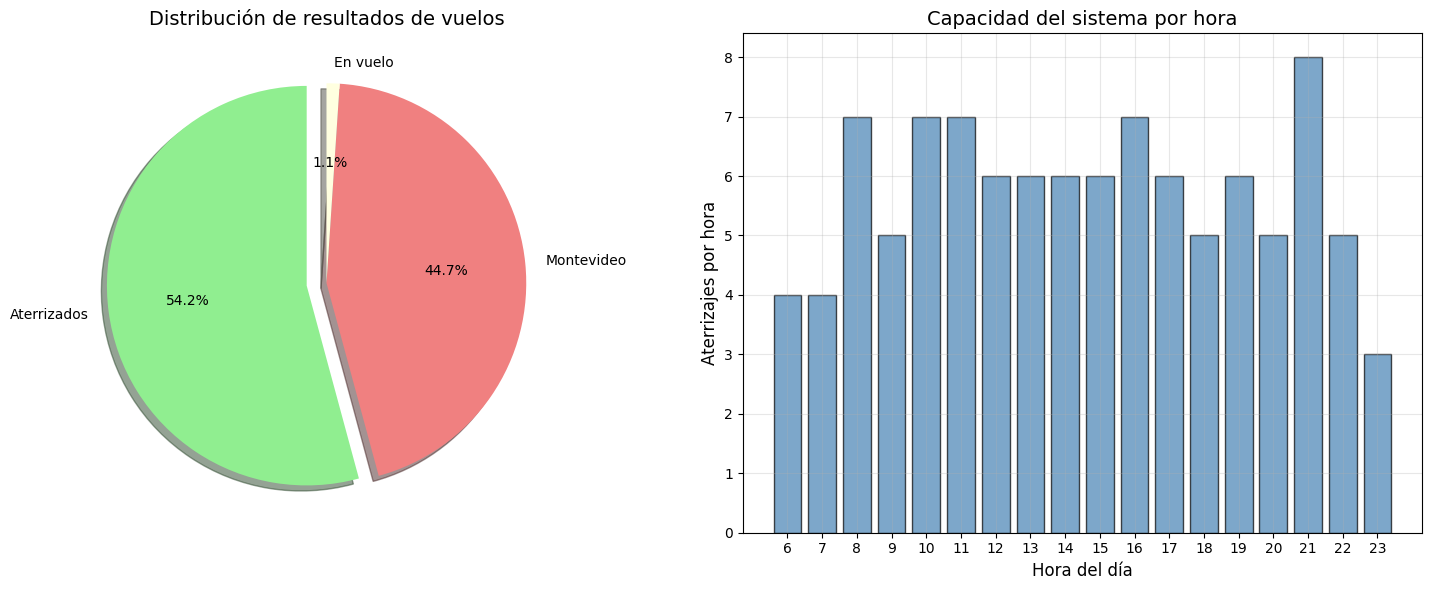

In [14]:
plot_system_efficiency(planes)